# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
import collections
from sklearn.decomposition import PCA
import operator
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()
azdias.shape
# (891221, 85)

azdias.describe()

azdias.isnull().sum().sum()
# 4896838

4896838

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
feat_info['missing_or_unknown'].iloc[57] = feat_info['missing_or_unknown'].iloc[57].replace('X','-1')
feat_info['missing_or_unknown'].iloc[58] = feat_info['missing_or_unknown'].iloc[58].replace('XX','-1')
feat_info['missing_or_unknown'].iloc[59] = feat_info['missing_or_unknown'].iloc[59].replace('XX','-1')

In [4]:
#This maps all defined null values to actual null values
for i in range(azdias.shape[1]):
    if feat_info.iloc[i].missing_or_unknown == '[]':
            pass
    else:
        azdias.iloc[:,i] = azdias.iloc[:,i].replace(eval(feat_info.iloc[i].missing_or_unknown),np.nan)

In [5]:
azdias.iloc[:,57].replace('X',np.nan, inplace=True)
azdias.iloc[:,58].replace('XX',np.nan, inplace=True)
azdias.iloc[:,59].replace('XX',np.nan, inplace=True)

In [55]:
azdias.shape

(891221, 85)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

null_columns=azdias.columns[azdias.isnull().any()]
data = azdias[null_columns].isnull().sum()

#Histogram shows >200,000 look like outliers and there are 5/6 of them
#plt.hist(data)

#This gives the reference rows for columns with really larger outliers
#
cols=[]

for i in range(len(data)):
     if data.iloc[i] > 200000:
            cols.append(i)

cols        
# 0   685843
# 3   392318
# 17   889061
# 19   310267
# 23   584612
# 40   476524    

#This gets the values of the outliers
#data.iloc[0]
        
#The above column numbers should be removed due to high proportion of null values
#print(data)

[0, 3, 17, 19, 23, 40]

In [9]:
# Investigate patterns in the amount of missing data in each column.
collections.Counter(data).most_common(12)

[(116515, 7),
 (4854, 6),
 (133324, 6),
 (73499, 4),
 (93148, 4),
 (111196, 3),
 (99352, 3),
 (93740, 3),
 (77792, 2),
 (158064, 2),
 (97375, 2),
 (685843, 1)]

In [7]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias.drop(azdias.columns[cols],axis=1,inplace=True)

azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,3,4,3,5,5,3,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,1,1996.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,1979.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,6,1957.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,5,1963.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

There are a few columns with a lot of missing data. There are 6 outliers on the histogram showing the number of nulls in each column. I have removed columns with index in [0,3,17,19,23,40]. These all have over 35% of the data missing. The field TITEL_KZ has the most unknown values (99.8%).

There are some columns which have the same amount of missing values. For example, LP_FAMILIE_FEIN and LP_FAMILIE_GROB. They are basically the same variable, just on a fine and a rough scale. 

There are a lot of features in the data dictionary that are very similar and could definitely be removed in PCA, as they will be highly corralated and not producing any more information.

The most frequent number of mising values is 116,515 occurs 7 times and comes from the PLZ8 variables. This could be that if you don't know 1 of the answers you're unlikely to know the others. Again, these are highly corralated variables and some should probably be removed in PCA.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(array([  6.68439000e+05,   8.15200000e+04,   3.35430000e+04,
          1.15200000e+04,   2.68800000e+03,   3.28000000e+02,
          1.55900000e+03,   1.70010000e+04,   8.02000000e+02,
          7.38210000e+04]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.]),
 <a list of 10 Patch objects>)

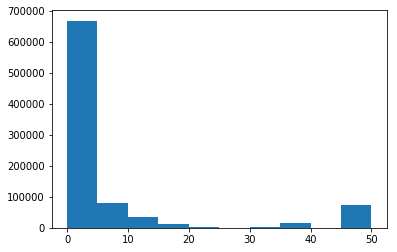

In [14]:
# How much data is missing in each row of the dataset?

nul_rows = azdias.isnull().sum(axis=1)

plt.hist(nul_rows)
#Histogram shows tailing off of null values to 25/30 and then outliers further right than that.
#Therefore I'll split the data at  > 30 nulls values

In [15]:
collections.Counter(nul_rows).most_common(30)
#45,578 rows have 50 missing values and 27,349 have 47 missing values

[(1, 202379),
 (2, 169262),
 (3, 124442),
 (0, 97720),
 (4, 74636),
 (50, 45578),
 (47, 27349),
 (5, 22049),
 (6, 17901),
 (7, 16916),
 (9, 13109),
 (10, 12109),
 (8, 11545),
 (11, 10489),
 (12, 6803),
 (36, 5220),
 (35, 3953),
 (16, 3376),
 (37, 2945),
 (38, 2906),
 (17, 2874),
 (14, 2297),
 (15, 2209),
 (39, 1977),
 (18, 1852),
 (13, 1845),
 (34, 1420),
 (19, 1209),
 (20, 1187),
 (21, 640)]

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

less_30_nulls = azdias[azdias.isnull().sum(axis=1) < 30]

more_30_nulls = azdias[azdias.isnull().sum(axis=1) >= 30]

In [17]:
print(less_30_nulls.shape, more_30_nulls.shape)

(798038, 79) (93183, 79)


In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#Drop columns where there are any nulls values, to find columns to compare with no null values
null_cols1=less_30_nulls.columns[less_30_nulls.isnull().any()]
less_30_nulls.drop(null_cols1, axis = 1, inplace = True)

null_cols2 = more_30_nulls.columns[more_30_nulls.isnull().any()]
more_30_nulls.drop(null_cols2,axis=1, inplace = True)

print("<30:", less_30_nulls.shape, ">30:", more_30_nulls.shape)


<30: (798038, 33) >30: (93183, 24)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [19]:
#All these columns are common so we will look at 5 of these
intersect_cols = np.intersect1d(list(less_30_nulls.columns.values), list(more_30_nulls.columns.values))

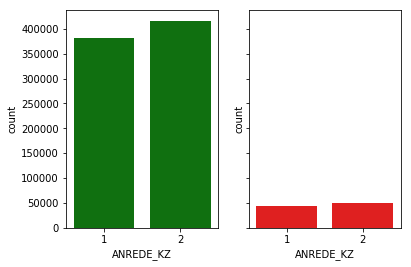

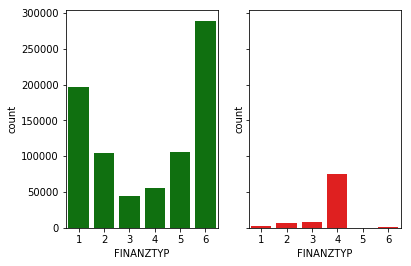

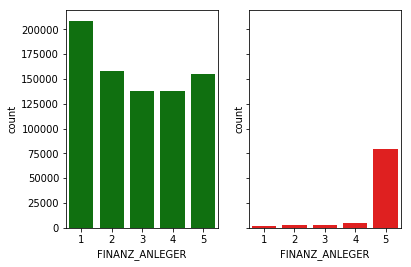

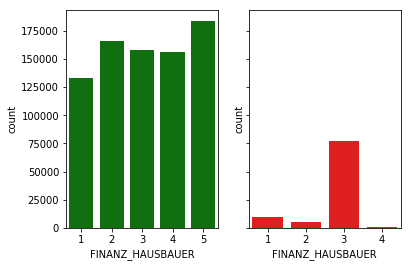

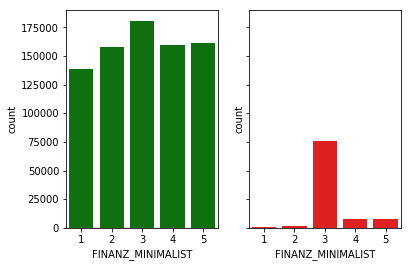

In [20]:
# compare distributions
for col in intersect_cols[:5]:
    fig, axes = plt.subplots(1,2,sharey=True)
    sns.countplot(less_30_nulls[col], ax=axes[0], color='g')
    sns.countplot(more_30_nulls[col], ax=axes[1], color='r')

In [8]:
new_data = azdias[azdias.isnull().sum(axis=1) < 30]
new_data.shape

(798038, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

In the histogram I produced, you see that over 30 null values in a column seems to be outside the norm. Therefor I chose to split the data at less than or greater than 30 outliers per row.

I then compared columns in the two datasets that had no missing values and found that the distributions were very different. This could be due to the process of completing the questionare, for example, if a household is completing it and leaves a lot of things blank as they might have a different attitude or mindset when answering the rest of the questions, giving a drastly different result.

As the columns with > 30 null values are so differently distributed, I will remove them from this analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [23]:
# How many features are there of each data type?
feat_info.groupby(['type']).size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

There are 21 categorical variables and 7mixed variables that will need to be reencoded.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [9]:
new_feat_info = feat_info.drop(cols) #Dropping columns we removed earlier for null values
new_feat_info2 = new_feat_info[new_feat_info['type']=='categorical']
new_feat_info2.drop([2,13,39,41,55,58],inplace =True) #Dropping columns that don't need to be one hot encoded & 58 to be dropped

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
#Manually replacing binary columns
new_data['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
new_data['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
new_data['ANREDE_KZ'].replace([2.0, 1.0], [1, 0], inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [11]:
new_data.shape

(798038, 79)

In [12]:
#Gets columns that are categorical
categorical_cols = new_feat_info2.attribute.tolist()

#One hot encoding columns in above list
new_data = pd.get_dummies(new_data, prefix_sep="__", columns = categorical_cols)

#### Discussion 1.2.1: Re-Encode Categorical Features
I have decided to drop only 1 column. Column 58, CAMEO_DEU_2015. I am doing this because it has a lot of values so would create a large volume for one hot encoding. It also has exactly the same number of null values as CAMEO_DEUG_2015 and from the data dictionary, I would assume contain very similar information, so removing it will not impact the model.

I am  leaving GREEN_AVANTGARDE and SOHO_KZ as they are as they only have 2 values of 0 and 1.

I am coding the OST_WEST column in binary as 1 and 0 from O and W and also the columns VERS_TYPE and ANREDE_KZ as they are currently 1 and 2 and will be changed to 1 and 0.

All the other remaining categorical variables will be encoded via one hot encoding.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [31]:
feat_info[feat_info['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,-1]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
new_data['PRAEGENDE_JUGENDJAHRE_decade'] = new_data['PRAEGENDE_JUGENDJAHRE'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], [1,1,2,2,3,3,3,4,4,5,5,5,5,6,6])
new_data['PRAEGENDE_JUGENDJAHRE_mov'] = new_data['PRAEGENDE_JUGENDJAHRE'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], [0,1,0,1,0,1,1,0,1,0,1,0,1,0,1])

In [33]:
new_data.shape

(798038, 133)

In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#Gets the first digit
new_data['CAMEO_INTL_2015_Wealth'] = pd.to_numeric(new_data['CAMEO_INTL_2015'].str.strip().str[-1])
#Gets the second digit
new_data['CAMEO_INTL_2015_Life_T'] = pd.to_numeric(new_data['CAMEO_INTL_2015'].str.strip().str[-2])

In [35]:
new_data.shape

(798038, 135)

In [36]:
new_data['WOHNLAGE_rural'] = new_data['WOHNLAGE'].replace([1,2,3,4,5,7,8],[0,0,0,0,0,1,1])
##new_data['KBA05_BAUMAX_bus_flag'] = new_data['KBA05_BAUMAX'].replace([1,2,3,4,5],[0,0,0,0,1]) 
##new_data['PLZ8_BAUMAX_bus_flag'] = new_data['PLZ8_BAUMAX'].replace([1,2,3,4,5],[0,0,0,0,1]) 

In [37]:
new_data.shape

(798038, 136)

In [38]:
new_data.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE','KBA05_BAUMAX','PLZ8_BAUMAX'],axis=1, inplace=True)

In [39]:
new_data.shape

(798038, 129)

#### Discussion 1.2.2: Engineer Mixed-Type Features

There are 7 mixed variable features.

1. I will remove both LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB as firstly, they are reasonably complex to split out and aren't consistent for each bit of sub information. Secondly, the variables LP_FAMILIE_GROB and LP_STATUS_GROB combined basically cover the information provided by the above two, hence I don't think removing them will impact the model.
2. I have mapped PRAEGENDE_JUGENDJAHRE to two new variables, one for the decade and one for the movement type and removed the original.
3. For WOHNLAGE, I have decided to create just a rural flag using this variable and drop the original variable. I am doing this because REGIOTYP covers the neighbourhood aspect of WOHNLAGE, however, I don't see another variable that encompasses a rural flag that we have kept in the data set, and as such it could be useful.
4. CAMEO_INTL_2015 has been split by digit into two new variables for wealth and Life type, with the original dropped.
5. I am dropping the columns KBA05_BAUMAX and PLZ8_BAUMAX because they both have a lot of null values.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [40]:
#pd.set_option('display.max_columns', 15)
new_data.dtypes

ALTERSKATEGORIE_GROB            float64
ANREDE_KZ                         int64
FINANZ_MINIMALIST                 int64
FINANZ_SPARER                     int64
FINANZ_VORSORGER                  int64
FINANZ_ANLEGER                    int64
FINANZ_UNAUFFAELLIGER             int64
FINANZ_HAUSBAUER                  int64
GEBURTSJAHR                     float64
GREEN_AVANTGARDE                  int64
HEALTH_TYP                      float64
SEMIO_SOZ                         int64
SEMIO_FAM                         int64
SEMIO_REL                         int64
SEMIO_MAT                         int64
SEMIO_VERT                        int64
SEMIO_LUST                        int64
SEMIO_ERL                         int64
SEMIO_KULT                        int64
SEMIO_RAT                         int64
SEMIO_KRIT                        int64
SEMIO_DOM                         int64
SEMIO_KAEM                        int64
SEMIO_PFLICHT                     int64
SEMIO_TRADV                       int64


In [69]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
new_data.dtypes.unique()

#All columns in the data are now numerical and all object variables have been dealt with or removed.

array([dtype('float64'), dtype('int64'), dtype('uint8')], dtype=object)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def clean_data(df, feat_info = feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """    
    # Put in code here to execute all main cleaning steps:
    #Converting most missing values to null
    feat_info['missing_or_unknown'].iloc[57] = feat_info['missing_or_unknown'].iloc[57].replace('X','-1')
    feat_info['missing_or_unknown'].iloc[58] = feat_info['missing_or_unknown'].iloc[58].replace('XX','-1')
    feat_info['missing_or_unknown'].iloc[59] = feat_info['missing_or_unknown'].iloc[59].replace('XX','-1')
    
    for i in range(df.shape[1]):
        if feat_info.iloc[i].missing_or_unknown == '[]':
            pass
        else:
            df.iloc[:,i] = df.iloc[:,i].replace(eval(feat_info.iloc[i].missing_or_unknown),np.nan)
    
    #Replacing the X's with nulls
    df.iloc[:,57].replace('X',np.nan, inplace=True)
    df.iloc[:,58].replace('XX',np.nan, inplace=True)
    df.iloc[:,59].replace('XX',np.nan, inplace=True)
    
    #Removing columns with > 200000 null values
#     null_columns=df.columns[df.isnull().any()]
#     null_data = df[null_columns].isnull().sum()

#     cols=[]

#     for i in range(len(null_data)):
#         if null_data.iloc[i] > 200000:
#             cols.append(i)

     #I'm making this less generalised so that the same columns in the customer data will be removed.       
            
    cols2 = [0, 3, 17, 19, 23, 40]
    
    #Drop the cols
    #df.drop(df.columns[cols],axis=1,inplace=True)
    
    df.drop(df.columns[cols2],axis=1,inplace=True)
    
    
    #Drop rows where there are over 30 null values
    new_data = df[df.isnull().sum(axis=1) < 30]
    
    #creating new feat_info
    new_feat_info = feat_info.drop(cols2) #Dropping columns we removed earlier for null values
    new_feat_info2 = new_feat_info[new_feat_info['type']=='categorical']
    new_feat_info2.drop([2,13,39,41,55,58],inplace=True) #Dropping columns that don't need to be one hot encoded & 58 to be dropped
    categorical_cols = new_feat_info2.attribute.tolist()

    #Replacing some variables with binary
    new_data['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    new_data['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    new_data['ANREDE_KZ'].replace([2.0, 1.0], [1, 0], inplace=True)

    #One hot encoding
    new_data = pd.get_dummies(new_data, columns = categorical_cols)

    #Re-engineering
    new_data['PRAEGENDE_JUGENDJAHRE_decade'] = new_data['PRAEGENDE_JUGENDJAHRE'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], [1,1,2,2,3,3,3,4,4,5,5,5,5,6,6])
    new_data['PRAEGENDE_JUGENDJAHRE_mov'] = new_data['PRAEGENDE_JUGENDJAHRE'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], [0,1,0,1,0,1,1,0,1,0,1,0,1,0,1])
    new_data['CAMEO_INTL_2015_Wealth'] = pd.to_numeric(new_data['CAMEO_INTL_2015'].str.strip().str[-1])
    new_data['CAMEO_INTL_2015_Life_T'] = pd.to_numeric(new_data['CAMEO_INTL_2015'].str.strip().str[-2])
    new_data['WOHNLAGE_rural'] = new_data['WOHNLAGE'].replace([1,2,3,4,5,7,8],[0,0,0,0,0,1,1])

    #Drop what we dont need
    new_data.drop(['CAMEO_DEU_2015'],axis=1, inplace=True)
    new_data.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE','KBA05_BAUMAX','PLZ8_BAUMAX'],axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return new_data
    

In [4]:
#azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
az_data = clean_data(azdias)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [5]:
az_data.shape

(798038, 129)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
print(round((az_data.isnull().sum(axis=0).sum()/(az_data.shape[0]*az_data.shape[1]))*100,2), "% of the data is null")

1.26 % of the data is null


In [6]:
# Replace all null values with the mean of the column
imp_mean = Imputer(missing_values = 'NaN', strategy='mean', axis=0)
az_data_imped = imp_mean.fit_transform(az_data)

In [7]:
az_data_imped.shape == az_data.shape

True

In [7]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
X_s = scaler.fit_transform(az_data_imped)

scaled_data = pd.DataFrame(X_s, columns=az_data.columns)

In [48]:
scaled_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_mov,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Life_T,WOHNLAGE_rural
0,-1.766035,0.957931,-1.494618,1.537966,-1.040680,1.466022,0.958707,1.339295,2.079101,-0.530419,...,-0.272887,-0.391100,-0.328975,2.221705,-0.395992,1.165663,-0.553142,-1.266408,1.191303,-0.552787
1,0.201250,0.957931,-1.494618,0.864599,-1.766957,-0.570972,0.244165,1.339295,0.856453,1.885301,...,-0.272887,-0.391100,-0.328975,-0.450105,-0.395992,1.165663,1.875371,0.761969,-0.865157,-0.552787
2,1.184893,0.957931,0.683130,-0.482135,1.138151,-0.570972,-1.184917,-0.791224,-0.725798,-0.530419,...,-0.272887,-0.391100,-0.328975,-0.450105,-0.395992,-0.232023,-0.553142,-0.590282,-1.550644,1.809017
3,0.201250,-1.043916,0.683130,0.191232,0.411874,-1.249969,0.244165,-0.791224,-0.294275,-0.530419,...,-0.272887,2.556891,-0.328975,-0.450105,-0.395992,-0.232023,-0.553142,0.085844,0.505817,-0.552787
4,-1.766035,0.957931,-0.042786,-1.155502,1.138151,-0.570972,-0.470376,1.339295,-1.732685,-0.530419,...,-0.272887,-0.391100,-0.328975,2.221705,-0.395992,-1.629709,-0.553142,0.761969,1.191303,1.809017


### Discussion 2.1: Apply Feature Scaling

Since such a small percentage of the data is null now, I'm going to impute and change the nulls to the means of the columns and then do standard scaling. Since most columns have just a small range of values, changing nulls to means shouldnt affect the modeling too much.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [53]:
# Apply PCA to the data.
pca = PCA()
x_pca = pca.fit_transform(scaled_data)

<Container object of 131 artists>

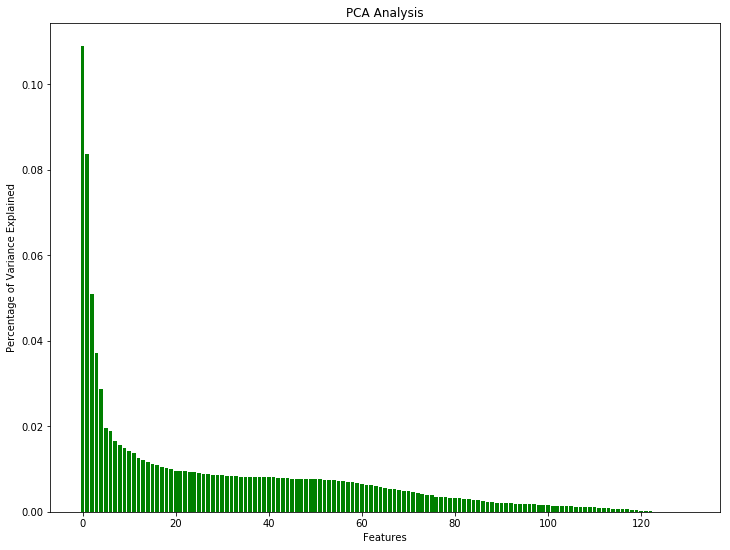

In [54]:
#calculate variance ratios
variance = pca.explained_variance_ratio_ 

num_features = len(variance)
x_axis = np.arange(num_features)

plt.subplots(figsize=(12,9))
plt.xlabel('Features')
plt.ylabel('Percentage of Variance Explained')
plt.title('PCA Analysis')

plt.bar(x_axis, variance, color = 'g')

In [55]:
#Sum them cumulatively
var=np.cumsum(np.round(variance, decimals=3)*100)

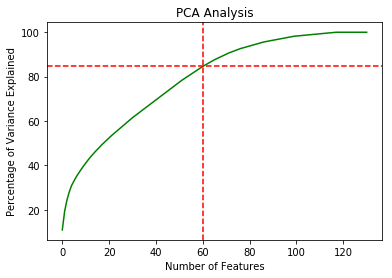

In [58]:
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')

plt.plot(var,color='g')
# plt.axhline(y=95, ls ='--',color = 'y')
# plt.axvline(x=85, ls ='--',color = 'y')

plt.axhline(y=85, ls ='--',color = 'r')
plt.axvline(x=60, ls ='--',color = 'r')

In [8]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Chosen to retain 60 components.
pca = PCA(60)
x_pca = pca.fit_transform(scaled_data)

In [10]:
x_pca.shape

(798038, 60)

### Discussion 2.2: Perform Dimensionality Reduction

The first graph and variance values show us that the first 6 features explain approximately 1/3 of the total variance. 

The second graph shows us that to achieve 85% of the variance explained, we need the 60 most important features.

Since getting 95% would require 15 more features, and 60 features is still a lot, I think 85% of the variance explained is sufficient, as such I will retain the top 60 features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [32]:
pca_red_data = pd.DataFrame(pca.components_,columns=scaled_data.columns)

pca_red_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_mov,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Life_T,WOHNLAGE_rural
0,-0.109757,0.012959,-0.206297,0.140842,-0.108421,0.074187,0.074574,0.145479,0.082875,-0.101924,...,-0.009678,0.001392,0.034278,0.091667,0.115274,0.099764,-0.099656,-0.113826,0.184715,-0.119942
1,0.222461,0.050242,0.061569,-0.213803,0.212137,-0.193433,-0.210414,0.111688,-0.189617,-0.019595,...,-0.007103,0.014140,0.015146,0.047678,0.033169,-0.234618,-0.018048,-0.003753,0.079208,-0.063220
2,0.025128,-0.352347,0.130169,-0.065020,0.059398,-0.155589,-0.059618,-0.047433,-0.054773,0.056433,...,-0.001345,-0.002492,0.000768,0.014752,0.022921,-0.065671,0.054176,-0.014258,0.024601,-0.036475
3,-0.019697,0.058493,0.034169,-0.002496,-0.011271,-0.094570,0.065585,-0.065267,0.025461,0.331792,...,0.024196,-0.033412,-0.018913,-0.022121,-0.022627,0.032116,0.331473,0.040430,-0.086855,-0.211734
4,0.060402,-0.035506,0.081144,-0.024649,0.001746,0.041565,-0.118336,-0.085253,0.010078,-0.087147,...,-0.035566,-0.007181,-0.005452,0.051848,0.063757,0.017330,-0.093027,-0.051765,0.091904,-0.009258


In [12]:
def get_pca_weights(pca, i):
    map_weights = {}
    for count, feature in enumerate(pca_red_data.columns):
        map_weights[feature] = pca.components_[i][count]
    
    sorted_weights = sorted(map_weights.items(), key=operator.itemgetter(1), reverse=True)
    
    return pd.DataFrame(sorted_weights,columns = ['variable','weight'])

In [13]:
def plot_top_bot_3(weights_pca, col):
    largest_3 = weights_pca.nlargest(3,'weight')
    smallest_3 = weights_pca.nsmallest(3,'weight')
    
    top_3_bot_3 = pd.concat([largest_3, smallest_3])
    
    var_order = [top_3_bot_3['variable'][0],top_3_bot_3['variable'][1],
                 top_3_bot_3['variable'][2],top_3_bot_3['variable'][126],
                 top_3_bot_3['variable'][127],top_3_bot_3['variable'][128]]
    
    ax = top_3_bot_3.set_index("variable").loc[var_order].plot(kind="bar", legend=False,color=col)
    ax.set_ylabel("Value")

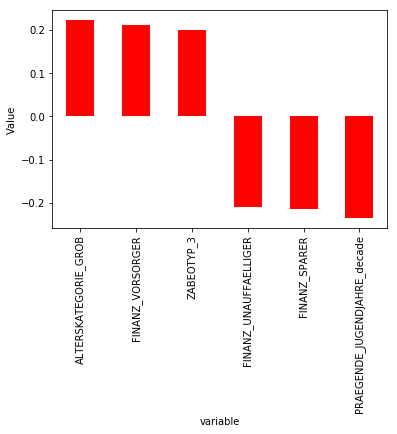

In [58]:
#Looking at the first principle component
weights_pca_1 = get_pca_weights(pca,1)
plot_top_bot_3(weights_pca_1, col = 'r')

The 6 most important features for the first component are:
- ALTERSKATEGORIE_GROB - the estimated age
- FINANZ_VORSORGER - how financially prepared people are
- ZABEOTYP_3 - if they look fr fair supplied energy
- FINANZ_UNAUFFAELLIGER - ordinary finance type
- FINANZ_SPARER - if they're a money saver
- PRAEGENDE_JUGENDJAHRE_decade - what decade dominated the person's youth

It seems like the first component is focused on the age and finance type of a customer, which are likely highly corralated. It has a positive corralation with age and a negative with the decade they grew up, as expected and positive corralation if they are finacially savy, and negative if they don't bother with finances too much.

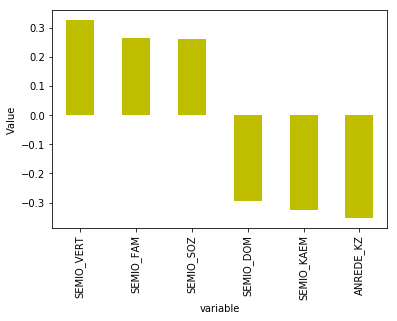

In [59]:
weights_pca_2 = get_pca_weights(pca,2)

plot_top_bot_3(weights_pca_2,col='y')

The 6 most important features for the second component are:
- SEMIO_VERT - how dreamful a person is
- SEMIO_FAM - how family oriented a person is
- SEMIO_SOZ - how social a person is
- ANREDE_KZ - gender
- SEMIO_KAEM - 	how combative a person is
- SEMIO_DOM - how dominating a person is

These centre around what kind of personality the person is. We have family oriented, dreamful and social are all positively corralated with each other which makes sense. And how domintating and combative a person is negatively corralated, and as these could be considered opposite this also makes sense.
The gender is interesting and I from the calculations below you can see that on average in this data, men are more dreamful, family oriented and sociable, which explains the negative corralation.

In [60]:
print("Man:",azdias['SEMIO_VERT'][azdias['ANREDE_KZ']== 1].sum()/len(azdias[azdias['ANREDE_KZ']== 1]))
print("Woman:",azdias['SEMIO_VERT'][azdias['ANREDE_KZ']== 2].sum()/len(azdias[azdias['ANREDE_KZ']== 2]))

print("Man:",azdias['SEMIO_FAM'][azdias['ANREDE_KZ']== 1].sum()/len(azdias[azdias['ANREDE_KZ']== 1]))
print("Woman:",azdias['SEMIO_FAM'][azdias['ANREDE_KZ']== 2].sum()/len(azdias[azdias['ANREDE_KZ']== 2]))

print("Man:",azdias['SEMIO_SOZ'][azdias['ANREDE_KZ']== 1].sum()/len(azdias[azdias['ANREDE_KZ']== 1]))
print("Woman:",azdias['SEMIO_SOZ'][azdias['ANREDE_KZ']== 2].sum()/len(azdias[azdias['ANREDE_KZ']== 2]))

Man: 5.61909155796
Woman: 2.56337885903
Man: 5.53553282807
Woman: 3.11682444848
Man: 5.09509621616
Woman: 2.89390829671


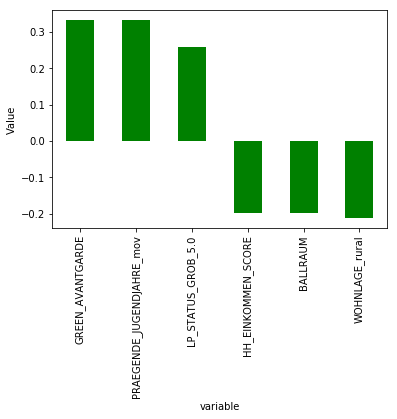

In [61]:
weights_pca_3 = get_pca_weights(pca,3)
plot_top_bot_3(weights_pca_3,col='g')

The 6 most important features for the third component are:
- PRAEGENDE_JUGENDJAHRE_mov - dominating movement of persons youth
- LP_STATUS_GROB_5.0 - top earners flag
- GREEN_AVANTGARDE - Membership in environmental sustainability as part of youth
- HH_EINKOMMEN_SCORE - Estimated household net income
- WOHNLAGE_rural - rural flag
- BALLRAUM - Distance to nearest urban center

The dominating movement of a persons youth and GREEN_AVANTGARDE are highly corralated, which makes sense as both are related to what a person did in their youth. The rural flag and distance to urban centre are corralated which makes sense.
This 3rd component seems to be about a persons upbringing and current financial situation.

### Discussion 2.3: Interpret Principal Components

Components discussed above.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [17]:
# Over a number of different cluster counts...
x_pca.shape


kmeans_3 = KMeans(n_clusters = 4, random_state=0).fit(x_pca)
#kmeans_3.fit(pca_red_data)
score_3 = kmeans_3.score(x_pca)

score_3

def modeling(k,data):
    kmeans = KMeans(k).fit(data)
    score = kmeans.score(data)
    return k, abs(score) 
    

In [35]:
modeling(10,x_pca)

(10, 63592815.079260588)

In [36]:
#This takes a long time to run to 31 so I stopped it at 15, which still takes a long time
x,y = [],[]
for k in range(2,16):
    x.append(modeling(k,x_pca)[0])
    y.append(modeling(k,x_pca)[1])
    print(k)

KeyboardInterrupt: 

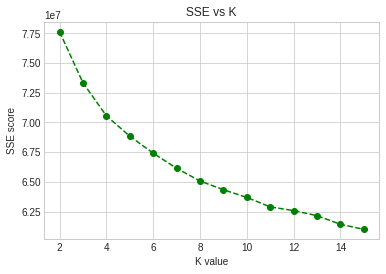

In [44]:
plt.style.use('seaborn-whitegrid')

plt.plot(x, y, '--ok', color='green');
plt.xlabel('K value');
plt.ylabel('SSE score');
plt.title('SSE vs K');

In [9]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 8, random_state= 0).fit(x_pca)

(array([  74290.,   99425.,  111211.,       0.,   96185.,  111027.,
              0.,   73123.,  134536.,   98241.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

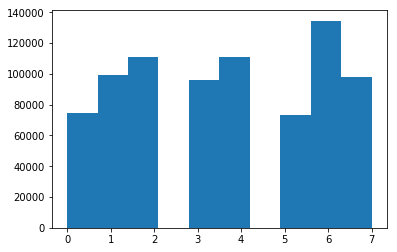

In [10]:
pop_labels = kmeans.predict(x_pca)  
plt.hist(pop_labels)

### Discussion 3.1: Apply Clustering to General Population

I have decided to go with 8 clusters. Looking at the graph I produced above, it is hard to tell exactly where the elbow is but it looks to be somewhere between 8 and 10. The 8 cluster model will run much quicker so I will proceed with this and hopefully we will find meaningful clustering.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [153]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
#customers.head()

cust_data = clean_data(customers)
cust_data.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(141724, 128)

In [154]:
for column in az_data.columns:
    if column not in cust_data.columns:
        print(column)

GEBAEUDETYP_5.0


In [155]:
#The above column was dropped in one hot encoding, so adding it back in with just zeros to the customer data.
cust_data['GEBAEUDETYP_5.0'] = 0

In [156]:
cust_data.shape

(141724, 129)

In [157]:
#Impute
imp_cust = imp_mean.transform(cust_data)

#Scale
scal_cust = scaler.transform(imp_cust)

#Apply PCA
final_cust = pca.transform(scal_cust)

final_cust.shape

(141724, 60)

(array([   1285.,  102252.,   13447.,       0.,    1213.,   12733.,
              0.,    2943.,    6276.,    1575.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

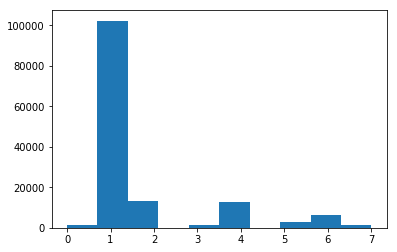

In [158]:
plt.hist(cust_labels)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [89]:
gen_pop_size = az_data.shape[0]
cust_pop_size = final_cust.shape[0]

gen_cluster_sizes = np.bincount(pop_labels)
cust_cluster_sizes = np.bincount(cust_labels)

In [39]:
no_rows_removed_nans_cust = customers.shape[0] - cust_data.shape[0]
no_rows_removed_nans_gen_pop = azdias.shape[0] - az_data.shape[0]

In [90]:
cust_cluster_sizes = list(cust_cluster_sizes)
cust_cluster_sizes.insert(0,no_rows_removed_nans_cust)

gen_cluster_sizes = list(gen_cluster_sizes)
gen_cluster_sizes.insert(0,no_rows_removed_nans_gen_pop)

In [114]:
np.array(cust_cluster_sizes)/cust_pop_size*100

array([ 35.22903672,   0.90669188,  72.14868336,   9.48816009,
         0.85588891,   8.98436398,   2.07657136,   4.42832548,   1.11131495])

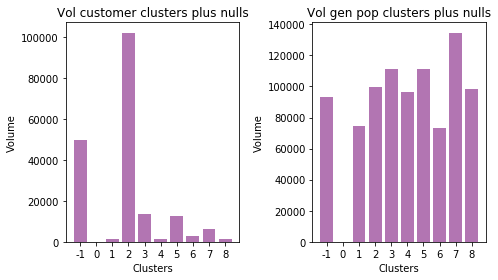

In [109]:
#Ploting the volumes of each cluster plus null values for the customer data
figure(num=None, figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.tight_layout()
#figure(num=None, figsize=(7, 4))
plt.xticks(np.arange(-1,9,1), np.arange(-1,9,1))
plt.bar([-1,1,2,3,4,5,6,7,8],cust_cluster_sizes, color = (0.5,0.1,0.5,0.6))
plt.title('Vol customer clusters plus nulls')
plt.xlabel('Clusters')
plt.ylabel('Volume')
plt.tight_layout()


#plotting the volumes of each cluster plus null values for the general population data.
plt.subplot(1,2,2)
plt.xticks(np.arange(-1,9,1), np.arange(-1,9,1))
plt.bar([-1,1,2,3,4,5,6,7,8],gen_cluster_sizes, color = (0.5,0.1,0.5,0.6))
plt.title('Vol gen pop clusters plus nulls')
plt.xlabel('Clusters')
plt.ylabel('Volume')
plt.tight_layout()


We can see that in the general population, the volume of null values does not look out of the ordinary for the cluster sizes, however in the customer data, the number of rows removed for too high null values is a much larger proportion and is the 2nd largest cluster.

In [22]:
z = no_rows_removed_nans_gen_pop/gen_pop_size

print("The percentage of the general population data where the row has more than 30 null values is "+"{:.2%}".format(z))

The percentage of the general population data where the row has more than 30 null values is 11.68%


In [21]:
x=no_rows_removed_nans_cust/cust_pop_size

print("The percentage of the customer data where the row has more than 30 null values is "+"{:.2%}".format(x))

The percentage of the customer data where the row has more than 30 null values is 35.23%


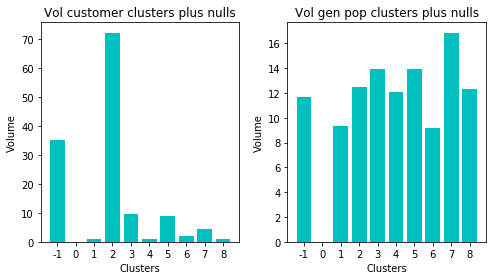

In [128]:
#Ploting the percentage each cluster holds plus null values for the customer data
figure(num=None, figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.tight_layout()
#figure(num=None, figsize=(7, 4))
plt.xticks(np.arange(-1,9,1), np.arange(-1,9,1))
plt.bar([-1,1,2,3,4,5,6,7,8],np.array(cust_cluster_sizes)/cust_pop_size*100, color = 'c')
plt.title('Vol customer clusters plus nulls')
plt.xlabel('Clusters')
plt.ylabel('Volume')
plt.tight_layout()


#plotting the percentage each cluster holds plus null values for the general population data.
plt.subplot(1,2,2)
plt.xticks(np.arange(-1,9,1), np.arange(-1,9,1))
plt.bar([-1,1,2,3,4,5,6,7,8],np.array(gen_cluster_sizes)/gen_pop_size*100, color = 'c')
plt.title('Vol gen pop clusters plus nulls')
plt.xlabel('Clusters')
plt.ylabel('Volume')
plt.tight_layout()



I have run the kmeans algorithm multiple times for 8 clusters and each time there in the customer data, there is 1 segment that holds most of the volume. In this iteration the 2nd cluster is massively over represented in the customer data set compared to the general population data. In gen pop 12.46% of customers are in segment 3, but in the customer data set 72.14% of customers are in segment 2. This would suggest that segment 2 would be the best target population for the company.

For the customer data there is also a much higher proportion of null valued rows (c.35% compared to 12%)

In [183]:
np.array(gen_cluster_sizes)/gen_pop_size*100 - np.array(cust_cluster_sizes)/cust_pop_size*100

array([ 35.22903672,   0.90669188,  72.14868336,   9.48816009,
         0.85588891,   8.98436398,   2.07657136,   4.42832548,   1.11131495])

In [160]:
#Do inverse transform to get centroids into origional space
cust_clusters_data = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)),columns = cust_data.columns)

In [165]:
cust_clusters_data

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_mov,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Life_T,WOHNLAGE_rural,GEBAEUDETYP_5.0
0,1.919839,-0.031974,1.857427,4.403761,2.053878,3.627777,3.810047,3.661555,1978.904206,0.097623,...,0.062792,0.119126,0.139769,0.287213,0.307706,5.687061,0.108083,2.103744,4.292619,0.045152
1,3.398082,0.500856,4.537697,1.545731,4.343638,1.732906,2.038552,2.196091,1959.739295,0.991510,...,0.063418,0.094283,0.039990,0.028580,0.014314,3.480122,0.992780,3.631687,2.018703,0.117097
2,3.291709,0.044998,3.335964,1.914881,4.257352,1.576285,1.714505,3.552920,1960.146699,0.097379,...,0.059414,0.159916,0.131524,0.312012,0.247688,3.483175,0.103803,2.388916,4.237443,0.055958
3,2.033080,0.967473,2.444482,3.860640,2.306822,4.321218,3.928242,2.686379,1977.035986,0.223080,...,0.082024,0.130749,0.061593,0.044538,0.023457,5.585318,0.232812,3.200055,2.430875,0.432782
4,3.555009,0.973358,2.651070,1.785228,4.336799,2.191249,1.667046,4.258139,1958.869754,0.079625,...,0.060626,0.179875,0.136351,0.310023,0.197656,3.246599,0.092856,2.721632,4.132951,0.087353
5,2.081613,-0.003082,3.614185,3.654829,2.326765,3.530721,3.859502,1.679106,1976.661338,0.363786,...,0.078109,0.114730,0.053514,0.040440,0.015244,5.513054,0.365911,3.259775,2.308662,0.433626
6,3.439294,0.485757,4.280232,1.570197,4.349107,2.389586,1.721948,2.490155,1959.623679,-0.009313,...,0.086204,0.126830,0.074189,0.031443,0.010814,3.394002,-0.004847,3.382435,2.428479,0.606391
7,1.822481,0.992063,1.133223,4.333767,2.269263,4.188998,3.748908,4.181355,1976.130304,0.029600,...,0.059051,0.120773,0.142423,0.302094,0.301158,5.536467,0.047568,2.100067,4.318617,0.009550


Looking at cluster 1 for the over represented cluster, we see that these customers are more likely to be male and are generally older, born late 50's to early 60's and are aged 46+. They are interested in finances, are big money savers and investors but don't feel financially prepared. Interestingly, almost all of them were involved in environment groups in their youth. They're also low for sensual and event oriented minds and much more religious and tradition minded.

In [164]:
cust_clusters_data.iloc[1]

ALTERSKATEGORIE_GROB               3.398082
ANREDE_KZ                          0.500856
FINANZ_MINIMALIST                  4.537697
FINANZ_SPARER                      1.545731
FINANZ_VORSORGER                   4.343638
FINANZ_ANLEGER                     1.732906
FINANZ_UNAUFFAELLIGER              2.038552
FINANZ_HAUSBAUER                   2.196091
GEBURTSJAHR                     1959.739295
GREEN_AVANTGARDE                   0.991510
HEALTH_TYP                         2.071717
SEMIO_SOZ                          4.087259
SEMIO_FAM                          3.420372
SEMIO_REL                          2.905190
SEMIO_MAT                          3.087885
SEMIO_VERT                         4.690118
SEMIO_LUST                         5.372850
SEMIO_ERL                          5.247378
SEMIO_KULT                         3.434145
SEMIO_RAT                          3.088398
SEMIO_KRIT                         4.378693
SEMIO_DOM                          4.727635
SEMIO_KAEM                      

In [184]:
cust_clusters_data.iloc[7]

ALTERSKATEGORIE_GROB               1.822481
ANREDE_KZ                          0.992063
FINANZ_MINIMALIST                  1.133223
FINANZ_SPARER                      4.333767
FINANZ_VORSORGER                   2.269263
FINANZ_ANLEGER                     4.188998
FINANZ_UNAUFFAELLIGER              3.748908
FINANZ_HAUSBAUER                   4.181355
GEBURTSJAHR                     1976.130304
GREEN_AVANTGARDE                   0.029600
HEALTH_TYP                         2.209134
SEMIO_SOZ                          3.243193
SEMIO_FAM                          3.857691
SEMIO_REL                          5.216463
SEMIO_MAT                          4.702608
SEMIO_VERT                         2.277628
SEMIO_LUST                         3.208247
SEMIO_ERL                          4.446564
SEMIO_KULT                         3.996560
SEMIO_RAT                          5.916718
SEMIO_KRIT                         5.472305
SEMIO_DOM                          6.083333
SEMIO_KAEM                      

Looking at cluster 8 for the under represented group, with a difference of 11% between the two datasets. In the general population, cluster 8 has 12.3% of the population, but in the customer data, only 1.1% are in cluster 8.

This segment seems to be a younger group of people, born in the 70's and mostly under 45. This group has more females in than segment 1 and they are much less financially savy, with low levels of home ownership, investing and saving. They are dreamful, social and family minded and are low for dominant and combatative traits.

### Discussion 3.3: Compare Customer Data to Demographics Data

See in line comments.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.